# Fit multiple potential SNIa with `sncosmo`

Import packages.

In [ ]:
import sncosmo
import iminuit
import numpy as np

/global/common/software/nersc/cori-2022q1/sw/python/3.9-anaconda-2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Define the  model for `sncosmo`.

In [ ]:
model = sncosmo.Model(source='salt2')

Read in the nightly epoch lightcurves for all "good" candidates from 2021.

In [ ]:
path = '../extragalactic_fields/candidate_nightly_epochs_files/'
fnm = path + 'candidate_lightcurves.dat'
candLC_field   = np.loadtxt(fnm, dtype='str', usecols=(0))
candLC_candid  = np.loadtxt(fnm, dtype='str', usecols=(1))
candLC_caldate = np.loadtxt(fnm, dtype='str', usecols=(2))
candLC_mjd     = np.loadtxt(fnm, dtype='float', usecols=(3))
candLC_filter  = np.loadtxt(fnm, dtype='str', usecols=(4))
candLC_Nobj    = np.loadtxt(fnm, dtype='int', usecols=(5))
candLC_mag     = np.loadtxt(fnm, dtype='float', usecols=(6))
candLC_mage    = np.loadtxt(fnm, dtype='float', usecols=(7))
candLC_mrb     = np.loadtxt(fnm, dtype='float', usecols=(8))
candLC_maglim  = np.loadtxt(fnm, dtype='float', usecols=(9))
del fnm

Read in the list of candidate IDs for potential SNIa that Melissa made with the MLG_snia_menagerie.ipynb notebook.

In [ ]:
path = '../extragalactic_fields/science_with_candidates/MLG_snia_menagerie_files/'
fnm = path + 'potential_snia_list.dat'
potSNIa_candid = np.loadtxt(fnm, dtype='str', usecols=(0))
del fnm

In [ ]:
# print(potSNIa_candid)

Define arrays to hold their fit results.

In [ ]:
fit_z   = np.zeros(len(potSNIa_candid), dtype='float')
fit_ze  = np.zeros(len(potSNIa_candid), dtype='float') 
fit_t0  = np.zeros(len(potSNIa_candid), dtype='float')
fit_t0e = np.zeros(len(potSNIa_candid), dtype='float')
fit_x0  = np.zeros(len(potSNIa_candid), dtype='float')
fit_x0e = np.zeros(len(potSNIa_candid), dtype='float')
fit_x1  = np.zeros(len(potSNIa_candid), dtype='float')
fit_x1e = np.zeros(len(potSNIa_candid), dtype='float')
fit_c   = np.zeros(len(potSNIa_candid), dtype='float')
fit_ce  = np.zeros(len(potSNIa_candid), dtype='float')

Run `sncosmo` for just 5 of the potential SNIa for now.

In [ ]:
for c in range(5):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')
    
    # do the fit like the example with sncosmo
    result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':(0.3, 0.7)})
    
    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']
    

See how the results arrays are populated.

In [ ]:
print(fit_z)

[0.41130085 0.50496126 0.32988932 0.55752008 0.50659747 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.        ]


Yup OK, looks like the basic process above is going to work OK.

**TO DO!!**

Add a step to the fitting process abobe that involves estimating the likely redshift range for the SNIa from its peak brightness, and then using that smaller range for the boundaries in the `sncosmo.fit_lc()` command.

Then do the fit for ALL the potential SNIa, not just 5.

Then, explore their results. You can make plots of the distributions of values, compare relations between values, look at which potential SNIa have big errors. 
___

## Estimating likely redshift range for fitting all potential SNIa

In [ ]:
# Check number of potential candidates
len(potSNIa_candid)

51

#### Run `sncosmo` (with additional step for redshift range)

In [12]:
for c in range(len(potSNIa_candid)):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')

##### EXTRA STEP #####

    # find redshift range for fit
    fluxarr = np.asarray(data['flux'], dtype='float')
    zparr = np.asarray(data['zp'], dtype='float')
    magarr = -2.5 * np.log10(fluxarr) + zparr
    min_magarr = np.min(magarr) ## calculate min mag from LC data
    estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift
    
    # use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to an error @ index 43, "result was NaN". Maybe that was too broad?)
    z_range = (estimated_redshift-0.08,estimated_redshift+0.08)

    # do the fit like the example with sncosmo
    result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':z_range})

##### EXTRA STEP #####

    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']

Check that the result arrays are fully populated

In [13]:
fit_z

array([0.30455414, 0.23534686, 0.13828473, 0.23711929, 0.24080981,
       0.26391213, 0.24372989, 0.09829047, 0.00817146, 0.23517217,
       0.21308467, 0.00408214, 0.20804926, 0.25144624, 0.30414446,
       0.19730807, 0.1330263 , 0.35715839, 0.27784635, 0.19667554,
       0.27298699, 0.08276718, 0.20185372, 0.13703677, 0.21852496,
       0.32272964, 0.05247889, 0.16165937, 0.12395756, 0.27885112,
       0.16028576, 0.11928276, 0.06894901, 0.23118046, 0.3090151 ,
       0.18675243, 0.31191442, 0.24865049, 0.31080331, 0.26790507,
       0.34836634, 0.14627623, 0.16404701, 0.1623938 , 0.3434681 ,
       0.27766421, 0.16518354, 0.32588273, 0.36071653, 0.12701025,
       0.15894617])

## Analyzing the results

In [14]:
import matplotlib.pyplot as plt

### Looking at the fit parameter distributions

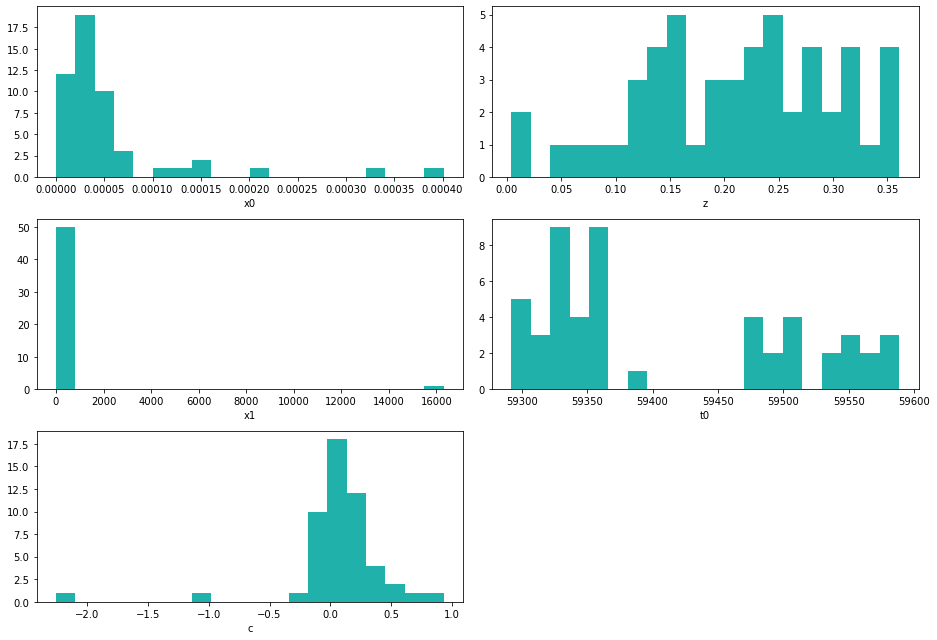

In [15]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 9)
fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[0,0].set_xlabel('x0')

ax[0,1].hist(fit_z, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[0,1].set_xlabel('z')

ax[1,0].hist(fit_x1, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[1,0].set_xlabel('x1')

ax[1,1].hist(fit_t0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[1,1].set_xlabel('t0')

ax[2,0].hist(fit_c, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[2,0].set_xlabel('c')

fig.tight_layout()
fig.show()

Each fit parameter (x0, x1, & c) seems to have a general range for values. However, the VERY outlying value of x1 potentially is making the rest of the distribution seem "normal". Perhaps these are the "normal" value ranges that indicate a good fit to SN Ia? (**I'll have to come back to this after reading papers) All these SN Ia have redshift z<~0.4

Let's look closer at the x1 distribution, omitting the x1= ~16000 point.

In [16]:
# Find which index in our fit_x1 array that has the extreme value
np.where(fit_x1 > 14000)

(array([43]),)

In [17]:
# Double-check the value
fit_x1[43]

16303.842852915046

In [18]:
# Create a new fit_x1 array that doesn't include the extreme value we just found
fit_x1_new = np.delete(fit_x1, 43, 0)
len(fit_x1_new)

50

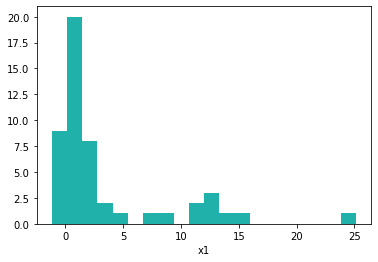

In [19]:
# Replot x1 data
plt.hist(fit_x1_new, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
plt.xlabel('x1');

This looks much better/more meaningful. Even x1~25 now looks to be an outlier. `x1 values seem to peak around 1.`

Outliers in each of these plots above could be indications of bad fits to type 1a supernovae? Let's look at the fitted plots for these candidates with such odd parameter values.

### Looking at the fits of candidates with outlying parameter values

#### Candidate 2

In [20]:
# Find which index in our fit_c array that has outlying value
np.where(fit_c < -2.0)

(array([2]),)

In [21]:
# Double-checking the value
fit_c[2]

-2.25628643285136

In [22]:
# Also want to check the other parameters
print(fit_x0[2])
print(fit_x1[2])

0.000401171169106386
1.0904914089006836




Interesting. The x0 value is another obvious outlier from its distribution, but its x1 actually appears to have a normal value! Maybe x1 values won't always indicate a good/bad fit to a SN Ia LC??

In [23]:
# Which candidate does this correspond to
potSNIa_candid[2]

'DC21foy'

In [24]:
my_potential_snia = 'DC21foy'
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

135


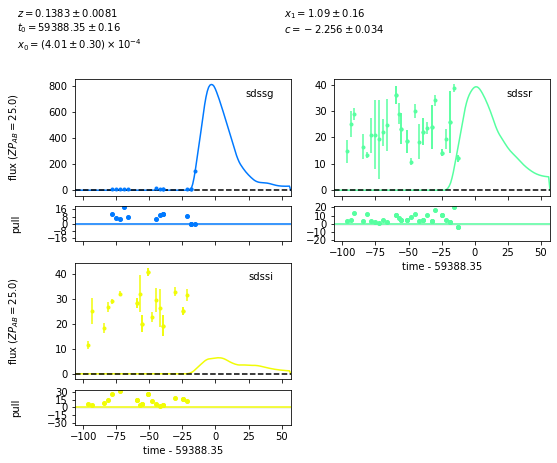

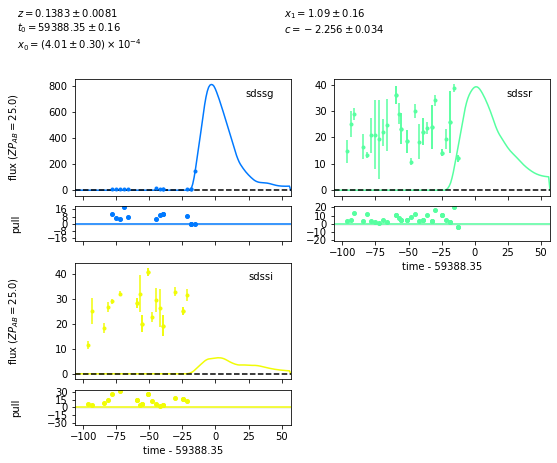

In [25]:
# Redo the fitting process and plot the fit as we've done

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data_foy = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data_foy['flux'], dtype='float')
zparr = np.asarray(data_foy['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result_foy, fitted_model_foy = sncosmo.fit_lc(data_foy, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})

sncosmo.plot_lc(data_foy, model=fitted_model_foy, errors=result_foy.errors)

This clearly isn't fitting the data well, which checks with what I expected since it had an outlying c & x0 values compared to their distributions. `sncosmo` fits SNIa, so this would tell us that either we don't have good data, or this candidate is not actually a type 1a supernova.

Let's check another candidate with weird parameter values.

#### Candidate 32

In [26]:
np.where(fit_x0 > 0.0003)

(array([ 2, 32]),)

In [27]:
# Index 2 already corresponds with the candidate we just looked at
fit_x0[32]

0.0003409605373582961

In [28]:
# Check other parameters
print(fit_x1[32])
print(fit_c[32])

0.0
0.0


In [29]:
# Which candidate does this correspond to
potSNIa_candid[32]

'DC21mjrj'

This is also interesting. Fit values for x1 and c are both 0, with an outyling x0 value. Let's look at the fitted LC.

In [30]:
my_potential_snia = 'DC21mjrj'
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

117


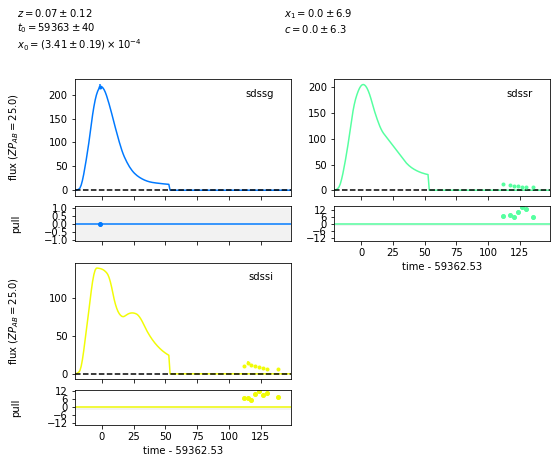

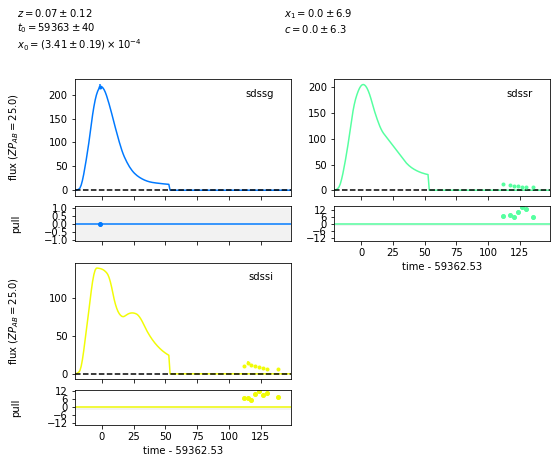

In [31]:
# Do the fitting process and plot the fit as we've done

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data_mjrj = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data_mjrj['flux'], dtype='float')
zparr = np.asarray(data_mjrj['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result_mjrj, fitted_model_mjrj = sncosmo.fit_lc(data_mjrj, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})

sncosmo.plot_lc(data_mjrj, model=fitted_model_mjrj, errors=result_mjrj.errors)

This also doesn't seem to fit the data well. Maybe we don't have a enough data? The g-band looks to only have one point to make a fit from. 

### Looking at the fit parameter error distributions

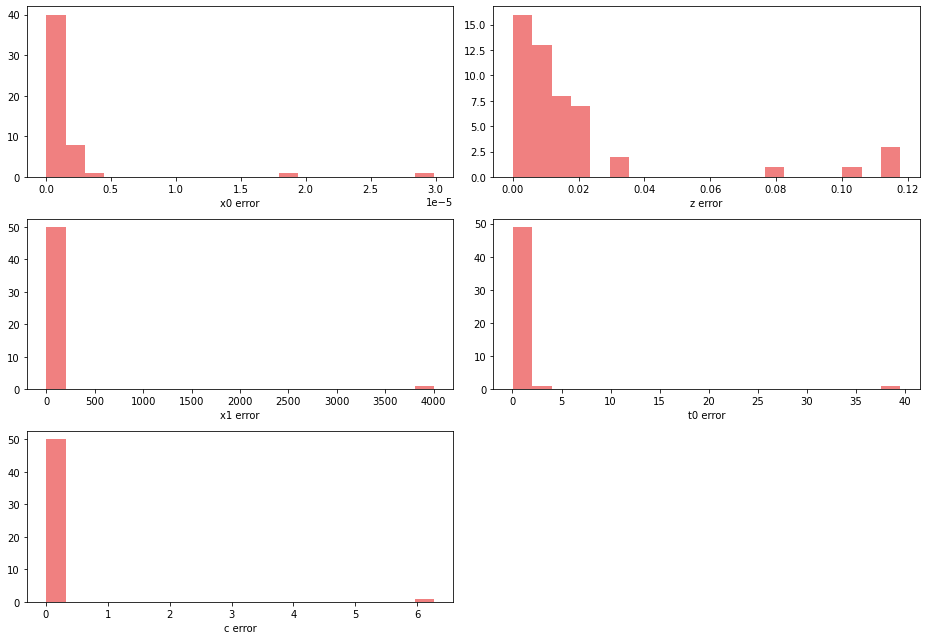

In [32]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 9)
fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[0,0].set_xlabel('x0 error')

ax[0,1].hist(fit_ze, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[0,1].set_xlabel('z error')

ax[1,0].hist(fit_x1e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[1,0].set_xlabel('x1 error')

ax[1,1].hist(fit_t0e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[1,1].set_xlabel('t0 error')

ax[2,0].hist(fit_ce, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[2,0].set_xlabel('c error')

fig.tight_layout()
fig.show()

Of course, we usually want to have the errors of our values pretty small, and the majority of our errors lie close to 0. That can indicate our values are pretty accurate. However, there are exceptions?

### Looking at the fits of candidates with large errors in parameters

Similarly as I did with candidates that have outlying parameter values, I will look at the fits of candidates that have large errors.

#### Candidate 43

In [33]:
np.where(fit_x1e > 3500)

(array([43]),)

In [34]:
fit_x1e[43]

4003.817746415814

In [35]:
# Check other parameter errors
print(fit_x0e[43])
print(fit_ce[43])

3.1158114890117546e-08
0.028957674622156416


It's x0 error is also very large. I also realize x1 and c distributions might look a bit different if we omitted the outlying values. But let's look at this candidate's fit first.

In [36]:
# Which candidate does this correspond to
potSNIa_candid[43]

'DC21dglus'

In [37]:
my_potential_snia = 'DC21dglus'
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

117


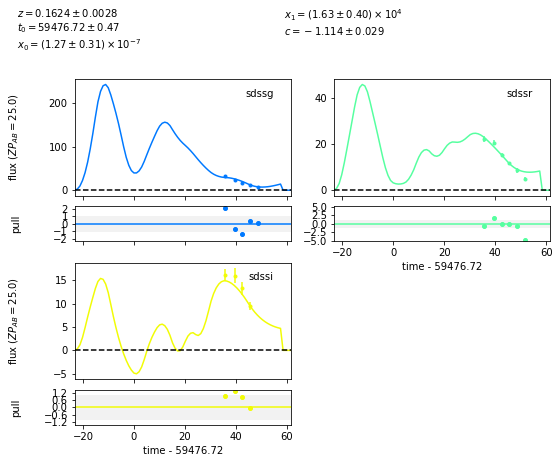

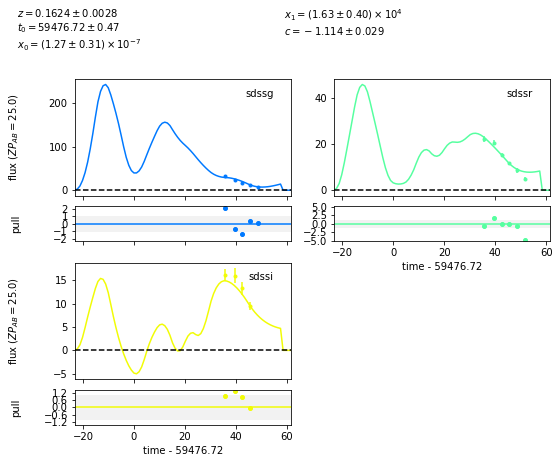

In [38]:
# Do the fitting process and plot the fit as we've done

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data_dglus = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data_dglus['flux'], dtype='float')
zparr = np.asarray(data_dglus['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result_dglus, fitted_model_dglus = sncosmo.fit_lc(data_dglus, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range})

sncosmo.plot_lc(data_dglus, model=fitted_model_dglus, errors=result_dglus.errors)

Yep, this is definetly not fit well. This fit also looks the worst compared to the fits oof candidates with outlying values from earlier. There are multiple maxima, nothing like a typical SNIa lightcurve.

Now lets revisit the error distributions of x1 and c errors, omitting some of the extreme values.

In [39]:
np.where(fit_x1e > 3500)

(array([43]),)

In [40]:
fit_x1e_new = np.delete(fit_x1e, 43, 0)

In [41]:
np.where(fit_ce > 6)

(array([32]),)

In [42]:
fit_ce_new = np.delete(fit_ce, 32, 0)

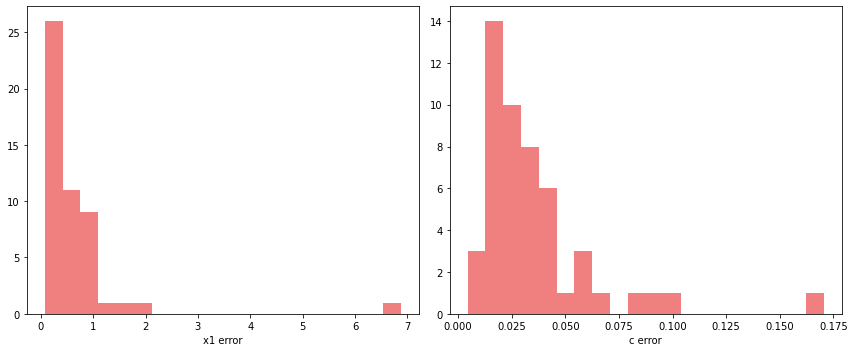

In [43]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

ax[0].hist(fit_x1e_new, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[0].set_xlabel('x1 error')

ax[1].hist(fit_ce_new, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[1].set_xlabel('c error')

fig.tight_layout()
fig.show()

Looks like we found some new "large" errors. So the c error for DC21dglus doesn't seem to be abnormal.

In [44]:
np.where(fit_ce > 6)

(array([32]),)

In [45]:
# Check other parameter errors
print(fit_x0e[32])
print(fit_x1e[32])

1.8503892472580294e-05
6.882389844154195


Both these values are decently large compared to the peak of their distributions.

In [46]:
# Which candidate does this correspond to
potSNIa_candid[32]

'DC21mjrj'

Oh this is the same candidate we looked at for outlying parameter values! So DC21mjrj had both odd parameter values AND errors.

### Comparing relations between values

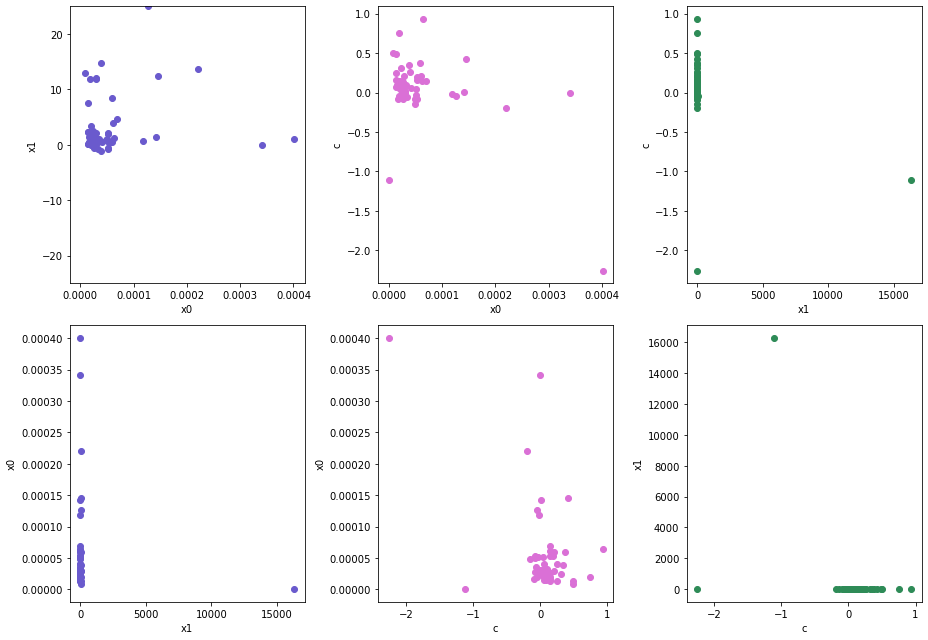

In [47]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(fit_x0, fit_x1, color='slateblue')
ax[0,0].set_ylim([-25,25])
ax[0,0].set_xlabel('x0')
ax[0,0].set_ylabel('x1')

ax[0,1].scatter(fit_x0, fit_c, color='orchid')
ax[0,1].set_xlabel('x0')
ax[0,1].set_ylabel('c')

ax[0,2].scatter(fit_x1, fit_c, color='seagreen')
ax[0,2].set_xlabel('x1')
ax[0,2].set_ylabel('c')

ax[1,0].scatter(fit_x1, fit_x0, color='slateblue')
ax[1,0].set_xlabel('x1')
ax[1,0].set_ylabel('x0')

ax[1,1].scatter(fit_c, fit_x0, color='orchid')
ax[1,1].set_xlabel('c')
ax[1,1].set_ylabel('x0')

ax[1,2].scatter(fit_c, fit_x1, color='seagreen')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel('x1')


fig.tight_layout()
fig.show()

Just some messing around with this section so far. I'm not sure if this tells us much? Maybe I'm doing this wrong.

<a href="https://sncosmo.readthedocs.io/en/stable/api/sncosmo.mcmc_lc.html#sncosmo.mcmc_lc"> MCMC chain for parameter estimation? Will this help at all?? IDK 
___

## Reanalyzing results w/ parameter *bounds*

Using bounds shown in the parameter distributions from papers <a href="https://academic.oup.com/mnras/article/504/3/4111/6225808"> here </a> and <a href="https://arxiv.org/abs/1401.4065"> here

`x0` does not have its own unique distribution, but rather is combined in the `mB` parameter where:

$m_{B}=−2.5log(x_{0})$   

*Note: the 2nd paper linked has an additional factor, +10.635, added to this equation*

### Getting x0 bounds

Using the equation above from the first paper, let's convert `mB` into `x0` so we can place bounds on the parameter.

Bounds for `mB`: about 17 to 28

Moving equation around to solve for x0:

### $x_{0}=10^{\frac{m_{B}}{-2.5}}$

In [48]:
x0_lower=10**(17/(-2.5))
x0_upper=10**(28/(-2.5))
print(f'Our upper and lower bounds for x0 are {x0_lower:.5g} and {x0_upper:.5g}')

Our upper and lower bounds for x0 are 1.5849e-07 and 6.3096e-12


This does seem like extremely narrow bounds, so maybe we can't extract x0 values this way? Let's try rerunning `sncosmo` with all the new/extra bounds, and look at the parameter distributions

### Looking at *bounded* fit parameter distributions

In [49]:
for c in range(len(potSNIa_candid)):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')


    # find redshift range for fit
    fluxarr = np.asarray(data['flux'], dtype='float')
    zparr = np.asarray(data['zp'], dtype='float')
    magarr = -2.5 * np.log10(fluxarr) + zparr
    min_magarr = np.min(magarr) ## calculate min mag from LC data
    estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift
    
    # use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to an error @ index 43, "result was NaN". Maybe that was too broad?)
    z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

    # do the fit like the example with sncosmo
    result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':z_range,'x0':(6.31e-12,1.58e10-7),'x1':(-3,3),'c':(-0.3,0.3)}) ## New parameter bounds for x0, x1 & c
    
    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']

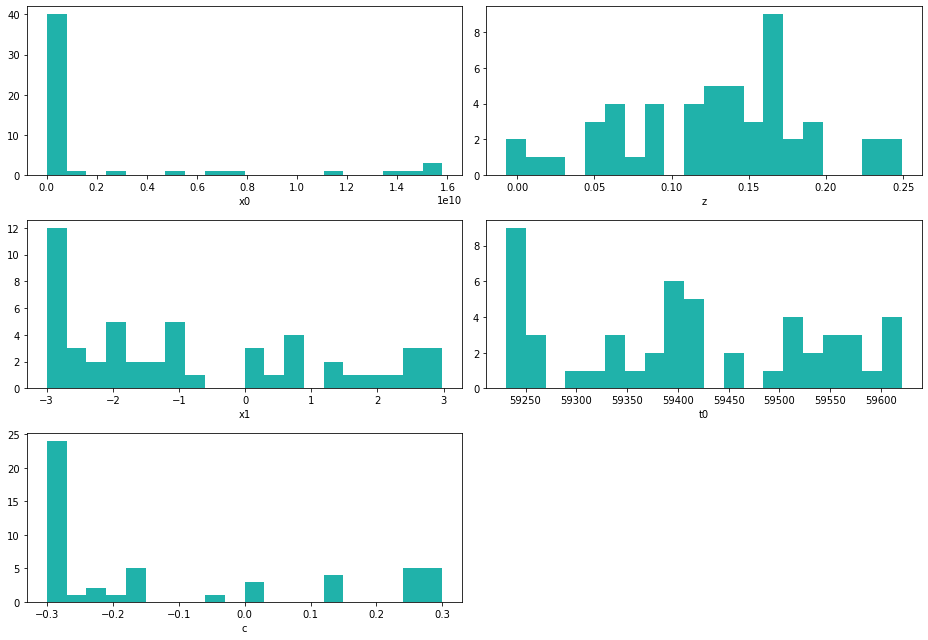

In [50]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 9)
fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[0,0].set_xlabel('x0')

ax[0,1].hist(fit_z, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[0,1].set_xlabel('z')

ax[1,0].hist(fit_x1, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[1,0].set_xlabel('x1')

ax[1,1].hist(fit_t0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[1,1].set_xlabel('t0')

ax[2,0].hist(fit_c, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[2,0].set_xlabel('c')

fig.tight_layout()
fig.show()

This seems odd. All the parameters seem to peak around their lower bounds. Let's do this again, omitting x0 bounds

In [51]:
for c in range(len(potSNIa_candid)):

    # identify the lightcurve points for this candidate
    tx = np.where(candLC_candid == potSNIa_candid[c])[0]
    
    # write the lightcurve to a temporary file
    fout = open('tempLC.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                       (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()
    
    del tx
    
    # read the file with sncosmo
    data = sncosmo.read_lc('tempLC.txt')


    # find redshift range for fit
    fluxarr = np.asarray(data['flux'], dtype='float')
    zparr = np.asarray(data['zp'], dtype='float')
    magarr = -2.5 * np.log10(fluxarr) + zparr
    min_magarr = np.min(magarr) ## calculate min mag from LC data
    estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift
    
    # use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to an error @ index 43, "result was NaN". Maybe that was too broad?)
    z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

    # do the fit like the example with sncosmo
    result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)}) ## New parameter bounds for x1 & c. Omitting x0 bounds
# 'x0':(6.31e-12,1.58e-07)
    
    params = result['parameters']
    errors = result['errors']
    fit_z[c]  = params[0]
    fit_t0[c] = params[1]
    fit_x0[c] = params[2]
    fit_x1[c] = params[3]
    fit_c[c]  = params[4]
    fit_ze[c]  = errors['z']
    fit_t0e[c] = errors['t0']
    fit_x0e[c] = errors['x0']
    fit_x1e[c] = errors['x1']
    fit_ce[c]  = errors['c']

In [52]:
estimated_redshift = 70.0 * 10.0**(((18 + 19.3) - 25.0)/5.0) / 500000.0
print(estimated_redshift)

0.040376441043772436


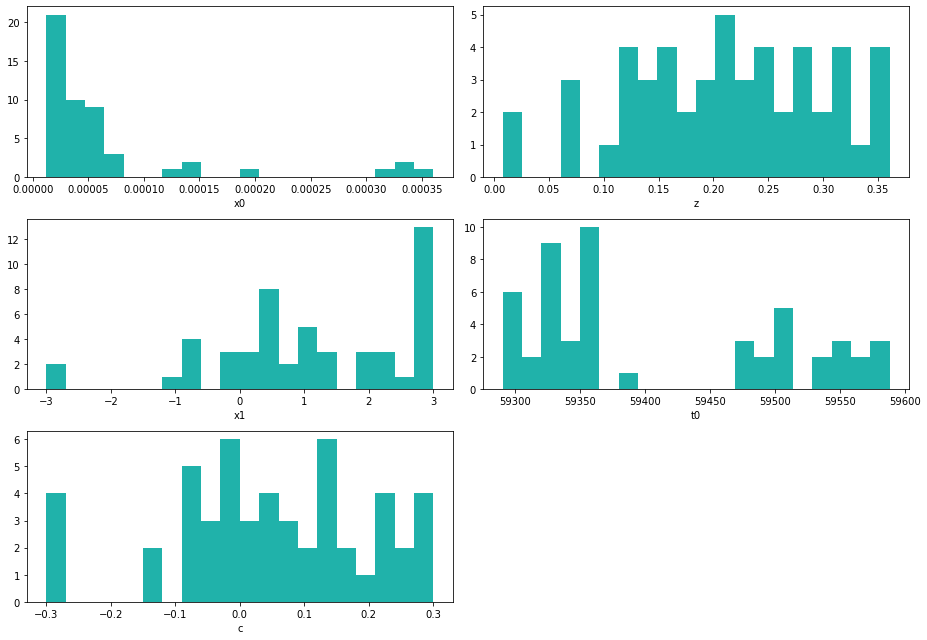

In [53]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 9)
fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[0,0].set_xlabel('x0')

ax[0,1].hist(fit_z, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[0,1].set_xlabel('z')

ax[1,0].hist(fit_x1, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[1,0].set_xlabel('x1')

ax[1,1].hist(fit_t0, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[1,1].set_xlabel('t0')

ax[2,0].hist(fit_c, bins=20, density=False, histtype='stepfilled', color='lightseagreen')
ax[2,0].set_xlabel('c')

fig.tight_layout()
fig.show()

Okay, so x1 and c distributions look better? Using the x0 bounds I had derived from mB did something weird to all the distribution plots. I'm not sure what went wrong, but I will say that the x0 bounds I derived looked quiet narrow already. Let's continue

### Looking at *bounded* fits of candidates with outlying parameter values

In [57]:
# Candidates associated with outlying x0 values
np.where(fit_x0 > 0.0003)

(array([ 2, 21, 26, 32]),)

In [58]:
# Candidates associated with outlying x1 values
np.where(fit_x1 < -2)

(array([26, 43]),)

In [59]:
# Candidates associated with outlying c values
np.where(fit_c < -0.2)

(array([ 2, 21, 26, 43]),)

Candidates of index 2, 43, and 32 also had outlying parameters initially. Index 21 and 26 are new.

#### Candidate 2

135


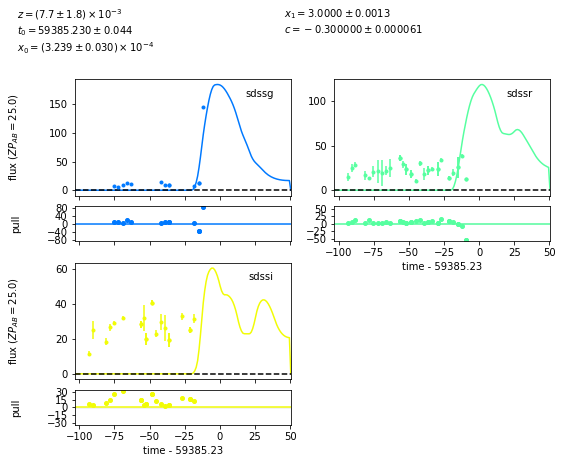

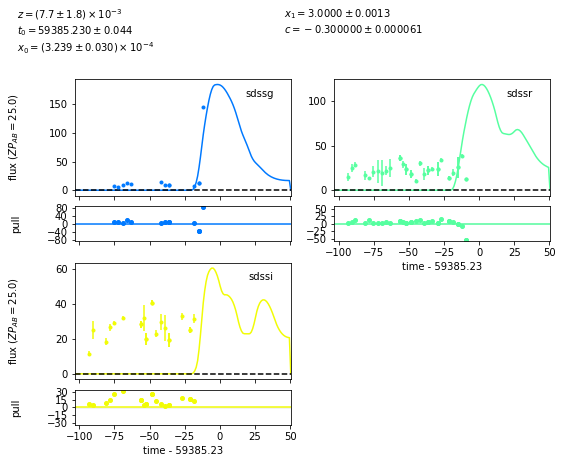

In [60]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[2])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 21

135


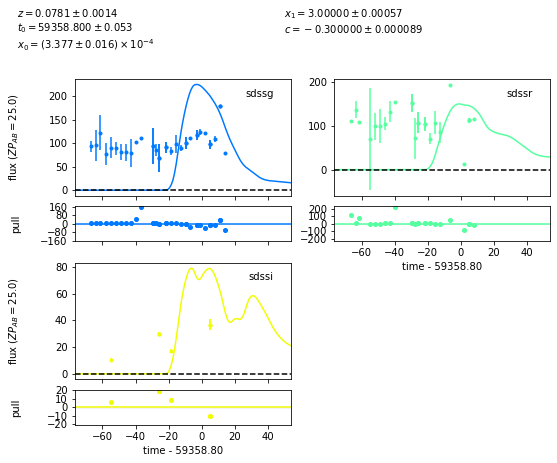

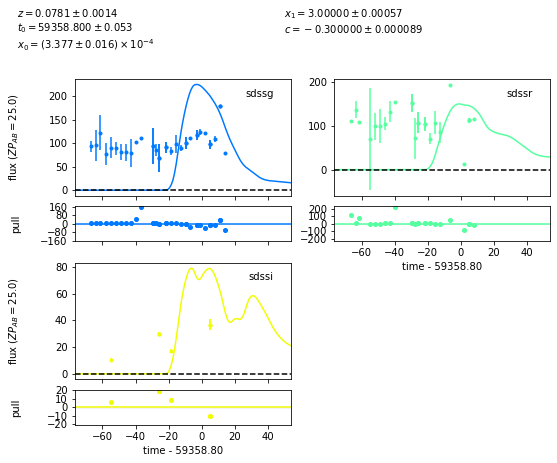

In [61]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[21])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 26

135


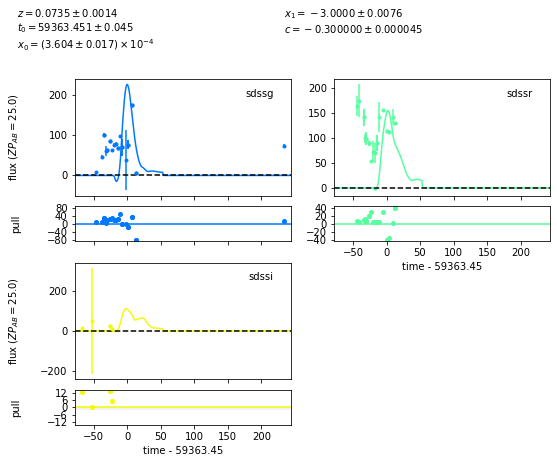

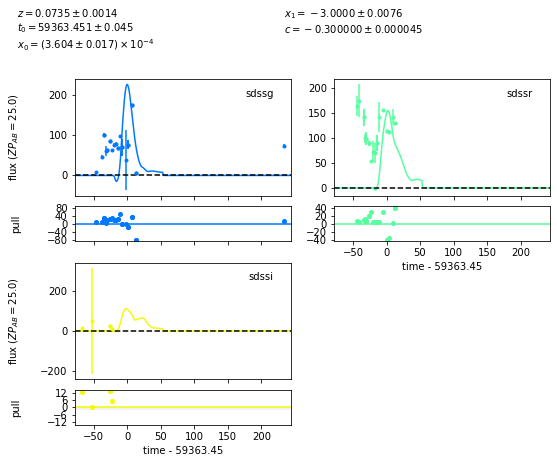

In [62]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[26])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 32

117


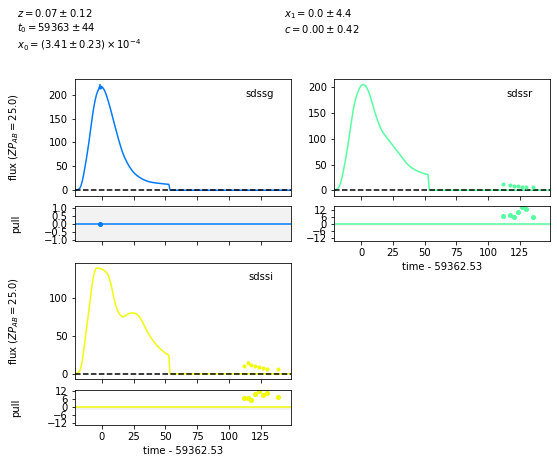

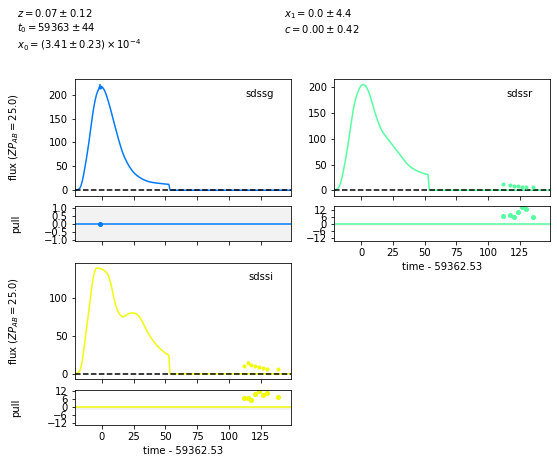

In [63]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[32])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

#### Candidate 43

117


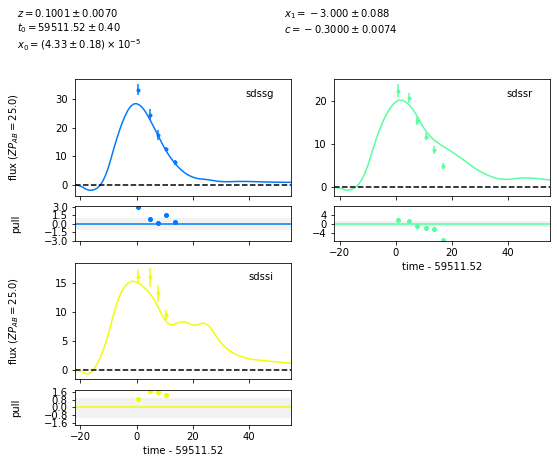

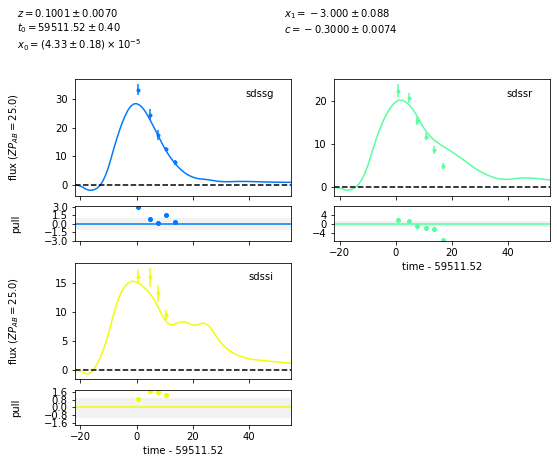

In [64]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[43])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

These fits don't look amazing, but compared to when we didn't have bounds on the x1 & c, these fits look much more SNIa-like despite having outlying parameter values. For example, w/out additional bounds, candidate 43 had many bumps and min/max in the fit, which would never occur in a real SNIa. Now, candidate 43 has just one maximum. Candidate 2, however, doesn't look much better from before.

### Attempting to plot all candidate fits at once (and failing)

AttributeError: 'AxesSubplot' object has no attribute 'sncosmo'

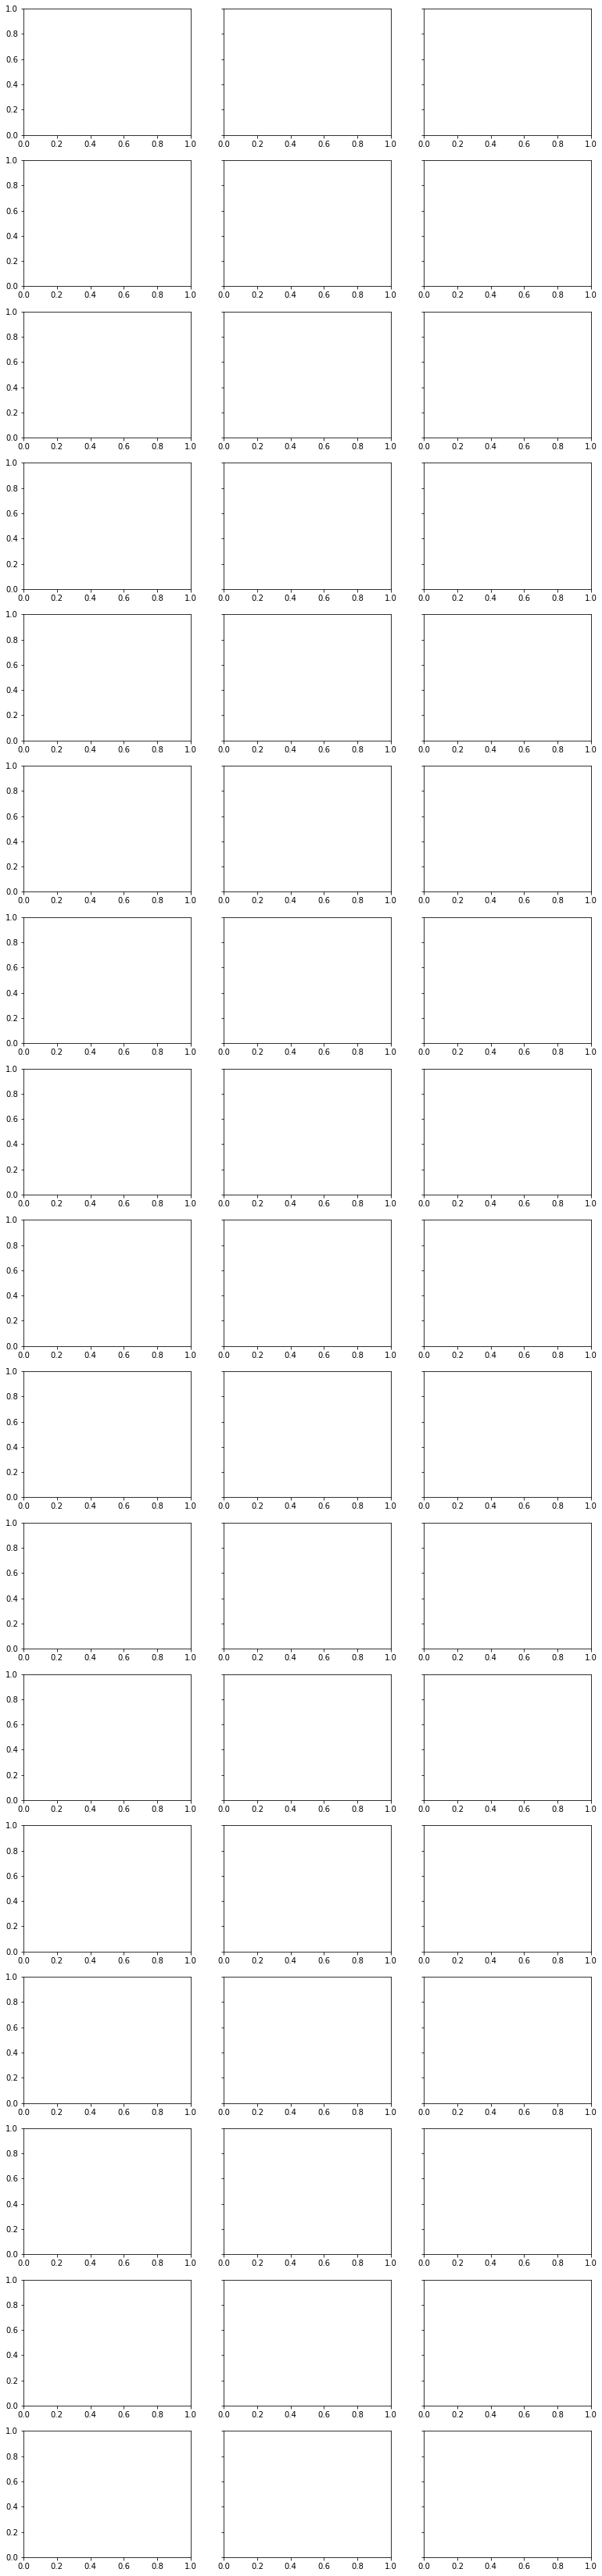

In [65]:
fig, ax = plt.subplots(17, 3, figsize=(13,60), sharex=False, sharey=True)

for i in range(len(potSNIa_candid)):
    my_potential_snia = (potSNIa_candid[i])
    tx = np.where(candLC_candid == my_potential_snia)[0]

    fout = open('test.txt', 'w')
    fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
    # fout.write('------------- ----- --------------- -------------- ---- ----- \n')
    for x in tx:
        if np.isfinite(candLC_mag[x]):
            flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
            fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
            fluxe = fluxhi - flux
            fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
    fout.close()

    data = sncosmo.read_lc('test.txt')

    fluxarr = np.asarray(data['flux'], dtype='float')
    zparr = np.asarray(data['zp'], dtype='float')
    magarr = -2.5 * np.log10(fluxarr) + zparr
    min_magarr = np.min(magarr) ## calculate min mag from LC data
    estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

    # use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
    z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

    # do the fit like the example with sncosmo
    result, fitted_model = sncosmo.fit_lc(data, model,
                                          ['z', 't0', 'x0', 'x1', 'c'],
                                          bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})
    for x in range(17):
        for y in range(3):
            ax[x,y].sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

### Looking at *bounded* fit parameter error distributions

In [ ]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(13, 9)
fig.delaxes(ax[2,1])

ax[0,0].hist(fit_x0e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[0,0].set_xlabel('x0 error')

ax[0,1].hist(fit_ze, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[0,1].set_xlabel('z error')

ax[1,0].hist(fit_x1e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[1,0].set_xlabel('x1 error')

ax[1,1].hist(fit_t0e, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[1,1].set_xlabel('t0 error')

ax[2,0].hist(fit_ce, bins=20, density=False, histtype='stepfilled', color='lightcoral')
ax[2,0].set_xlabel('c error')

fig.tight_layout()
fig.show()

### Looking at *bounded* fits of candidates with large error in parameters

In [ ]:
# Candidates associated with large x0 errors
np.where(fit_x0e > 0.8)

In [ ]:
# Candidates associated with large x1 errors
np.where(fit_x1e > 4)

In [ ]:
# Candidates associated with large c errors
np.where(fit_ce > 0.4)

So we already detected candidate 32 from having outlying parameter values. Candidate 7 is new, so let's take a look at it's fit.

#### Candidate 7

In [ ]:
# Do the fitting process and plot the fit as we've done

my_potential_snia = (potSNIa_candid[7])
tx = np.where(candLC_candid == my_potential_snia)[0]
print(len(tx))

fout = open('test.txt', 'w')
fout.write('     time      band       flux         fluxerr      zp  zpsys \n')
# fout.write('------------- ----- --------------- -------------- ---- ----- \n')
for x in tx:
    if np.isfinite(candLC_mag[x]):
        flux = 10.0**((candLC_mag[x] - 25.0)/(-2.5))
        fluxhi = 10.0**(((candLC_mag[x]-candLC_mage[x]) - 25.0)/(-2.5))
        fluxe = fluxhi - flux
        fout.write('%13.4f %5s %15.7f %14.7f  25.  ab \n' % \
                   (candLC_mjd[x], 'sdss'+candLC_filter[x], flux, fluxe))
fout.close()

data = sncosmo.read_lc('test.txt')

fluxarr = np.asarray(data['flux'], dtype='float')
zparr = np.asarray(data['zp'], dtype='float')
magarr = -2.5 * np.log10(fluxarr) + zparr
min_magarr = np.min(magarr) ## calculate min mag from LC data
estimated_redshift = 70.0 * 10.0**(((min_magarr + 19.3) - 25.0)/5.0) / 500000.0 ## estimate redshift

# use a broad redshift range +/-0.08 (+/-0.1 like in previous notebook led to NaN error @ index 43, maybe that was too broad?)
z_range = (estimated_redshift-0.08, estimated_redshift+0.08)

# do the fit like the example with sncosmo
result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z', 't0', 'x0', 'x1', 'c'],
                                      bounds={'z':z_range,'x1':(-3,3),'c':(-0.3,0.3)})

sncosmo.plot_lc(data, model=fitted_model, errors=result.errors)

## Re-Comparing relations between values

In [ ]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(13, 9)

ax[0,0].scatter(fit_x0, fit_x1, color='slateblue')
#ax[0,0].set_ylim([-2,3.1])
ax[0,0].set_xlabel('x0')
ax[0,0].set_ylabel('x1')

ax[0,1].scatter(fit_x0, fit_c, color='orchid')
ax[0,1].set_xlabel('x0')
ax[0,1].set_ylabel('c')

ax[0,2].scatter(fit_x1, fit_c, color='seagreen')
ax[0,2].set_xlabel('x1')
ax[0,2].set_ylabel('c')

ax[1,0].scatter(fit_x1, fit_x0, color='slateblue')
ax[1,0].set_xlabel('x1')
ax[1,0].set_ylabel('x0')

ax[1,1].scatter(fit_c, fit_x0, color='orchid')
ax[1,1].set_xlabel('c')
ax[1,1].set_ylabel('x0')

ax[1,2].scatter(fit_c, fit_x1, color='seagreen')
ax[1,2].set_xlabel('c')
ax[1,2].set_ylabel('x1')


fig.tight_layout()
fig.show()

Still not seeing any correlation between parameters